In [ ]:
import json
import math
import os
import requests
import scipy
import tifffile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

!pip3 install tensorflow_decision_forests --upgrade
import tensorflow_decision_forests as tfdf
import pandas as pd

from datetime import datetime as dt
from scipy import stats as st
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.layers import concatenate
from keras import metrics
from keras.models import Sequential
from keras.layers import Activation, Dense
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential
from keras.layers import Dense

#!pip install tensorflow==2.7
from keras import metrics
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

from google.colab import drive
from google.colab import files
drive.mount('/content/drive/')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Read Tiles Dataset**

In [ ]:
dataset = pd.read_csv(r'/content/drive/MyDrive/capstone/Tiles_binned.csv')

In [ ]:
dataset.head(5)

,Tile_ID,Long2,Lat2,Long1,Lat1,Mid_lat,Mid_long,Stop_Signs,Paving_historical,Paving_future,Bus_stop,Collisions_Future,Collisions_Historical,RTTYP,bin
0,36,-122.514446,37.779636,-122.513306,37.778732,37.779184,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,M,A
1,37,-122.514446,37.778732,-122.513306,37.777829,37.778280,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,M,A
2,151,-122.513306,37.779636,-122.512166,37.778732,37.779184,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,M,A
3,152,-122.513306,37.778732,-122.512166,37.777829,37.778280,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,M,A
4,153,-122.513306,37.777829,-122.512166,37.776925,37.777377,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,M,A


In [ ]:
dataset.columns

Index(['Tile_ID', 'Long2', 'Lat2', 'Long1', 'Lat1', 'Mid_lat', 'Mid_long',
       'Stop_Signs', 'Paving_historical', 'Paving_future', 'Bus_stop',
       'Collisions_Future', 'Collisions_Historical', 'RTTYP', 'bin'],
      dtype='object')

**Pre-processing for Multi-Class Classification**

Need pre-processing string to int for multi-class labels https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(dataset['bin'])
dataset['label'] = le.transform(dataset['bin'])

**Test-Train Split (sklearn)**

In [ ]:
# x: 'Tile_ID', 'Mid_lat', 'Mid_long',
#    'Stop_Signs', 'Bus_stop', 'Paving', 'Future', 'Historical',
#    'Collision_binary_historical'
# y: 'Collision_binary_future'

X = dataset[['Tile_ID', 'Long2', 'Lat2', 'Long1', 'Lat1', 'Mid_lat', 'Mid_long',
           'Stop_Signs', 'Paving_historical', 'Paving_future', 'Bus_stop',
           'Collisions_Future', 'Collisions_Historical']]
y = dataset[['label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.2)

In [ ]:
y_train.label.unique()

array([ 0,  3,  1,  4,  2,  8,  6,  7,  5,  9, 10])

**LOGISTIC REGRESSION (SKLEARN)**

https://machinelearningmastery.com/multinomial-logistic-regression-with-python/

In [ ]:
# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Mean Accuracy: 0.791 (0.000)


**LOGISTIC REGRESSION (TENSORFLOW)** 
From W207 HW4

In [ ]:
def build_model(learning_rate=0.01):
  """Build a TF logistic regression model using Keras.

  Args:
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  # Build a model using keras.Sequential.
  model = keras.Sequential()

  # Keras layers can do pre-processing. This layer will take our [size?] images
  # and flatten them into vectors of [size?].
  model.add(keras.layers.Flatten())
  
  # This layer constructs the linear set of parameters for each input feature
  # (as well as a bias), and applies a Softmax to the result. The result is
  # multinomial logistic regression.
  model.add(keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      use_bias=True,               # use a bias param
      activation="Softmax"         # changed to Softmax
  ))

  # Use the SGD optimizer as usual.
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # We specify the categorical_crossentropy loss (equivalent to log loss).
  # Notice that we are including 'categorical_accuracy' as one of the metrics that we
  # ask Tensorflow to report when evaluating the model.
  model.compile(loss='categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=[metrics.categorical_accuracy])

  return model

In [ ]:
# Build the model.
model = build_model()

# Make a prediction for five inputs.
print(model.predict(X_train[0:5]))

1/1 [==============================] - 0s 434ms/step
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [ ]:
model = build_model(learning_rate=0.01)

# Fit the model.
history = model.fit(
  x = X_train,   # our binary training examples
  y = y_train,   # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size for SGD
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
display(history)

Epoch 1/5
95/95 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 2/5
95/95 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 3/5
95/95 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 4/5
95/95 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 5/5
95/95 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000


,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,0.0,1.0,0.0,1.0
1,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,1.0
4,0.0,1.0,0.0,1.0


In [ ]:
def create_linear_model():

    input = tf.keras.layers.Input(shape=(6,))
    
    #input_t = tf.data.Dataset.from_tensor_slices(input.to_dict(orient="list"))

   # normalized = layers.Normalization(input_shape=[5,], axis=None)(input)

   #x = normalizer(input_t)

    outputs = layers.Dense(1)(input)

    linear_model = tf.keras.models.Model(inputs=input, outputs=outputs, name="linear_model")

    linear_model.summary()

    linear_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy' #,
        #metrics = [tf.keras.metrics.Accuracy()]
        )
    
    return linear_model

linear_model = create_linear_model()

history = linear_model.fit(
    np.asarray(X_train[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']]).astype('float32'),
    y_train,
    epochs=20,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Model: "linear_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
168/168 [==============================] - 1s 3ms/step - loss: 4.0322e-08 - val_loss: 4.0389e-08
Epoch 2/20
168/168 [==============================] - 0s 2ms/step - loss: 4.0322e-08 - val_loss: 4.0389e-08
Epoch 3/20
168/168 [==============================] - 0s 2ms/step - loss: 4.0322e-08 - val_loss: 4.0389e-08
Epoch 4/20
168/168 [==============================] - 0s 2ms/step - loss: 4.0322e-08 - val_loss: 4.0389e-08
Epoch 5/20
168/168 [====

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([min(history.history['loss']), max(history.history['loss'])])
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)

<ipython-input-14-a3e2c8825cf8>:6: UserWarning: Attempting to set identical bottom == top == 4.032209943716225e-08 results in singular transformations; automatically expanding.
  plt.ylim([min(history.history['loss']), max(history.history['loss'])])


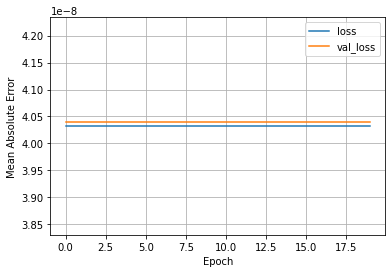

In [ ]:
plot_loss(history)

**RANDOM FOREST (TENSORFLOW)**

https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel

In [ ]:
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())

Use /tmp/tmpktymvc0f as temporary training directory
Reading training dataset...


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Training dataset read in 0:00:06.757256. Found 10471 examples.
Training model...
Model trained in 0:00:01.684072
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (15):
	Bus_stop
	Collisions_Future
	Collisions_Historical
	Lat1
	Lat2
	Long1
	Long2
	Mid_lat
	Mid_long
	Paving_future
	Paving_historical
	RTTYP
	Stop_Signs
	Tile_ID
	bin

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.                   "bin"  0.305955 ################
    2.     "Collisions_Future"  0.281623 ###########

**Decision Tree**

In [ ]:
from sklearn import tree
dtree = tree.DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)

y_pred_dtree = dtree.predict_proba(X_test)[:, 1]
fpr_dtree, tpr_dtree, thresholds_dtree = roc_curve(y_test, y_pred_dtree)
auc_dtree = auc(fpr_dtree, tpr_dtree)

ValueError: ignored

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_logr, tpr_logr, label='Decision Tree (area = {:.3f})'.format(auc_dtree))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve: Decision Tree')
plt.legend(loc='best')
plt.show()